In [1]:
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import seaborn as sns
from ipywidgets import interact, interact_manual
import numpy as np
import json
import shapely.geometry
from IPython.display import HTML, SVG, display

In [2]:
dta = pd.read_csv('../demand/Base_PNMfusion.csv', encoding='latin1')
dta['Pays_origine'] = dta['Secteur Origine'].apply(lambda r: r if r in ('France', 'Allemagne', 'Belgique') else 'Luxembourg')
dta['Pays_dest'] = dta['Secteur Destination'].apply(lambda r: r if r in ('France', 'Allemagne', 'Belgique') else 'Luxembourg')

In [3]:
zones = gpd.read_file('.')

There turned out to be flows in `dta` that have no counter-part in `zones`. This is somewhat complicated by zones being defined both by the origin and destination of a flow in `dta`. So let's first regroup everything in one mapping between zones and corridor that `dta` uses, and then see in a next step, whether we do or do not have geometries for that:

In [7]:
d = (pd.concat([(dta[[f'Corridor_PNM_{key}', f'Pays_{key}', key.capitalize()]]
                 .rename(columns={f'Corridor_PNM_{key}': 'corridor', f'Pays_{key}': 'country', key.capitalize(): 'zone'}))
                 for key in ('dest', )])
                 .drop_duplicates())
problems = d.groupby('zone').count().query('corridor > 1').query('corridor > 1').index
d.query('zone in @problems').sort_values(['zone', 'corridor', 'country']).to_excel('problems.xlsx')

In [8]:
zone2corridor = (pd.concat([(dta[[f'Corridor_PNM_{key}', f'Pays_{key}', key.capitalize()]]
                 .rename(columns={f'Corridor_PNM_{key}': 'corridor', f'Pays_{key}': 'country', key.capitalize(): 'zone'}))
                 for key in ('origine', )])  # by 'dest' produces weird results (see above)
                 .drop_duplicates()
                 .merge(zones[['NO', 'geometry']], left_on='zone', right_on='NO', how='left').drop('NO', axis=1))
zone2corridor = gpd.GeoDataFrame(zone2corridor).set_geometry('geometry')

## Corridors

Let's create them by melding communes by corridor name:

In [9]:
zone2corridor.dissolve(by=['corridor', 'country'])[['geometry']].reset_index().query('~geometry.isnull()').explore()

### Getting rid of "exclaves"

This produces several "MultiGeometries". While the 'ceinture urbaine' clearly is such an agglomerate region, all other cases seem "exclaves", where some geometry that does not really help identifying the overarching corridor still pops up and might mess with navigation in the browser later on. There is one notable exception though: Mondorf is allocated to A1/CFL30 instead of A13

In [16]:
zones.loc[zones.NAME.str.startswith('Mondorf')]

,NO,NAME,PAYS,geometry
141,13051,Mondorf-les-Bains,Luxembourg,"POLYGON ((6.29022 49.49716, 6.28889 49.49444, ..."


Except for 'Mondorf' and 'ceinture urbaine', let's get rid of enclaves that amount to less than 5% of the overall surface of the corridor:

In [17]:
corridors = zone2corridor.dissolve(by=['corridor', 'country'])[['geometry']].reset_index()

def simplify(geometry):
    if not hasattr(geometry, 'geoms'):
        return geometry
    areas = [g.area for g in geometry.geoms]
    areas = np.array(areas) / np.sum(areas)
    large_geom = [g for a, g in zip(areas, geometry.geoms) if a > 0.05]
    return shapely.geometry.MultiPolygon(large_geom) if len(large_geom) > 1 else large_geom[0]

corridors['geometry'] = corridors.geometry.apply(simplify)

Also, some polygons still contain 'holes'. Let's get rid of those:

In [19]:
def remove_holes(geometry):
    if geometry is None:
        return
    if hasattr(geometry, 'geoms'):
        return shapely.geometry.MultiPolygon([remove_holes(g) for g in geometry.geoms])
    return shapely.geometry.Polygon(geometry.exterior)

corridors['geometry'] = corridors['geometry'].apply(remove_holes)

And this looks promising:

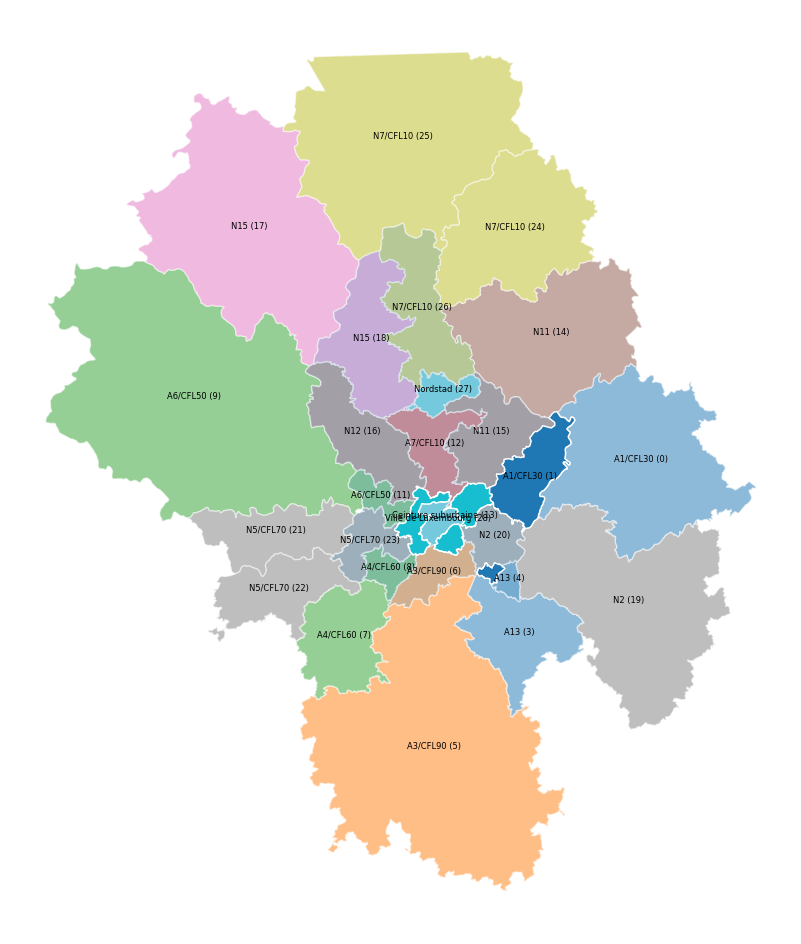

In [26]:
plt.figure(figsize=(12, 12))
ax = plt.subplot(111)
plt.axis('off')
corridors.plot(ax=ax, alpha=.5, edgecolor='w', linewidth=1, column='corridor')
corridors.query('country=="Luxembourg"').plot(ax=ax, edgecolor='w', linewidth=1, alpha=0.2)
corridors.query('~geometry.isnull()').loc[corridors.query('~geometry.isnull()').geometry.geom_type.str.startswith('Multi')].plot(ax=ax, column='corridor', linewidth=1, edgecolor='w')
corridors.query('~geometry.isnull()').apply(
    lambda x: ax.annotate(text='{} ({})'.format(x['corridor'], x.name),
                          xy=x.geometry.centroid.coords[0], 
                          ha='center', fontsize=6), axis=1);
plt.savefig('map.png', dpi=1200)

### Simplify respecting topology

Looking good. Now let's simplify thoses geometries - switching to LUREF coordinates at the same time to be able to specify distances in meters:

C:\Users\uuw336\mambaforge\envs\py310-gg\lib\site-packages\geopandas\geodataframe.py:1442: UserWarning: Geometry column does not contain geometry.
  warnings.warn("Geometry column does not contain geometry.")


<AxesSubplot: >

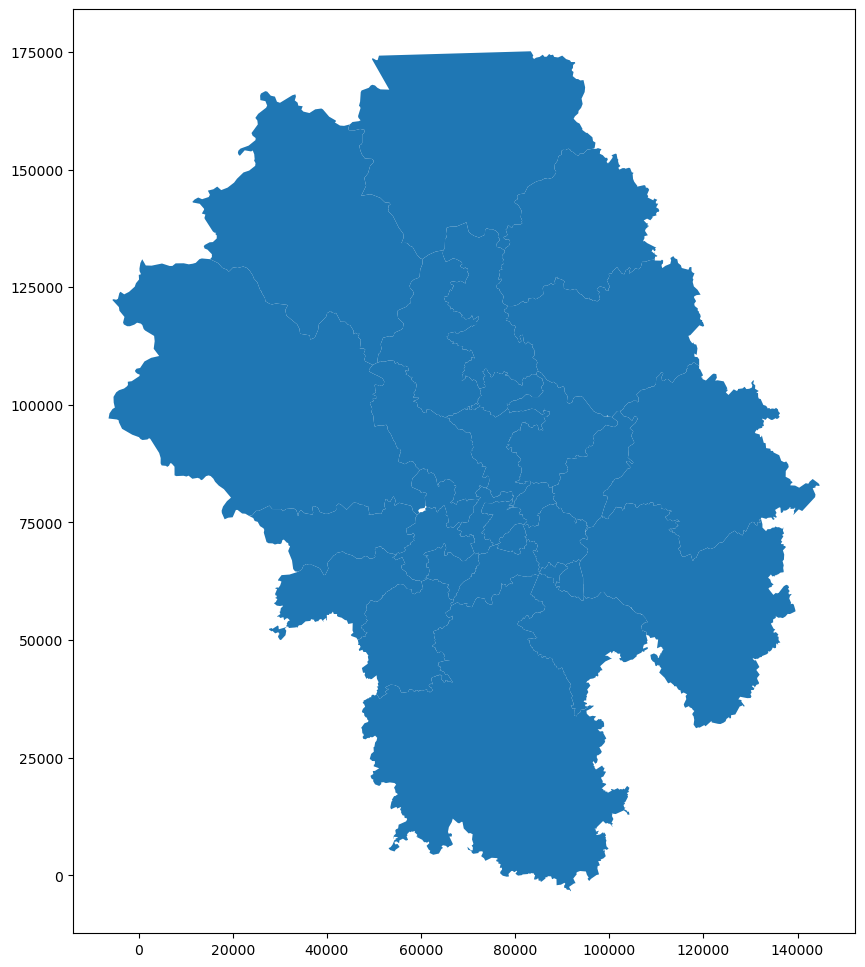

In [85]:
import topojson as tp

topo = corridors.copy()
topo['geometry'] = topo.geometry.to_crs(2169)
topo['geometry'] = tp.Topology(topo.geometry, shared_coords=True, prequantize=1e6).toposimplify(100, simplify_algorithm='dp').to_gdf()
topo.plot(figsize=(12, 12))

Cut geometries around LU to make graph more square - this can introduce some fragmentation leading to unnecessary multipolygons, so we apply `remove_holes` and `simply` (removal of small polygons):

In [87]:
import shapely.validation

In [95]:
miny = topo.query('corridor=="N2" & country=="Allemagne"').geometry.bounds.miny.values[0]
maxy = topo.query('corridor=="N15" & country=="Belgique"').geometry.bounds.maxy.values[0]

minx = topo.query('corridor=="N15" & country=="Belgique"').geometry.bounds.minx.values[0]
maxx = topo.query('corridor=="N11" & country=="Allemagne"').geometry.bounds.maxx.values[0] + 10000

topo_cut = topo.copy()
topo_cut['geometry'] = gpd.clip(topo['geometry'], [minx, miny, maxx, maxy], keep_geom_type=True)
topo_cut['geometry'] = topo_cut.geometry.apply(lambda r: None if r is None else shapely.validation.make_valid(r))  # necessary as clip disrupts some geoms
#topo_cut['geometry'] = topo_cut['geometry'].apply(simplify).apply(remove_holes)  # with `make_valid` seemingly no longer necessary
topo_cut.query('~geometry.isnull()').explore()

Finally, convert LUXREF coordinates to something I can manage in SVG - I'm not using shapely objects here, as plotting is no longer useful (would print the map upside-down, due to SVG's origin being in the top-left')

First, we'll need to scale the axes to something useful, namely such that whichever axis has the largest extent, that gets mapped to 1000 units:

In [96]:
points = 1000
dx = maxx - minx
dy = maxy - miny
f = max(dx, dy)
width, height = points / f * dx, points / f * dy
print(f'f: {f:.4f}')
print(f'width: {width:.1f}')
print(f'height: {height:.1f}')

f: 135371.5492
width: 877.3
height: 1000.0


In [172]:
def scale(coords, digits=3):
    shape = (np.array(coords) - [minx, miny]) / f * points
    shape[:, 1] = width - shape[:, 1]  # SVG -> origin in top-left corner
    return  np.round(shape, digits)

def to_svg_coords(g, wrap=True, **kwargs):
    if g is None:
        return []
    if hasattr(g, 'geoms'):
        return [to_svg_coords(s, **kwargs, wrap=False) for s in g.geoms]
    ret = scale(g.exterior.coords, **kwargs)
    if wrap:
        return [ret]
    return ret
        
def flatten_svg_group(group):
    group = [[','.join(str(s) for s in pair) for pair in path] for path in group]
    group = [' '.join(path) for path in group]
    return group

def adjusted_centroid(polygon):
    if polygon is None:
        return [np.nan, np.nan]
    if hasattr(polygon, 'geoms'):
        i, area = max(((i, g.area) for i, g in enumerate(polygon.geoms)), key=lambda r: r[1])
        geom = polygon.geoms[i]
    else:
        geom = polygon
    return geom.centroid.coords[0]

    
width = 1000
height = 1000 / (maxx - minx) * (maxy - miny)
svg_export = topo_cut.copy().sort_index().rename(columns={'Corridor': 'corridor', 'Pays': 'country'})
svg_export['paths'] = svg_export['geometry'].apply(to_svg_coords).apply(flatten_svg_group)
svg_export = pd.DataFrame(svg_export.drop('geometry', axis=1))
svg_export['centroid'] = list(scale(np.vstack(topo_cut['geometry'].apply(adjusted_centroid))))
svg_export['centroid'] = svg_export['centroid'].apply(lambda r: None if np.isnan(np.sum(r)) else r)  # only way I found to get rid of [nan, nan]
#svg_export = svg_export.reset_index().rename(columns={'index': 'id'})

Let's see if this works

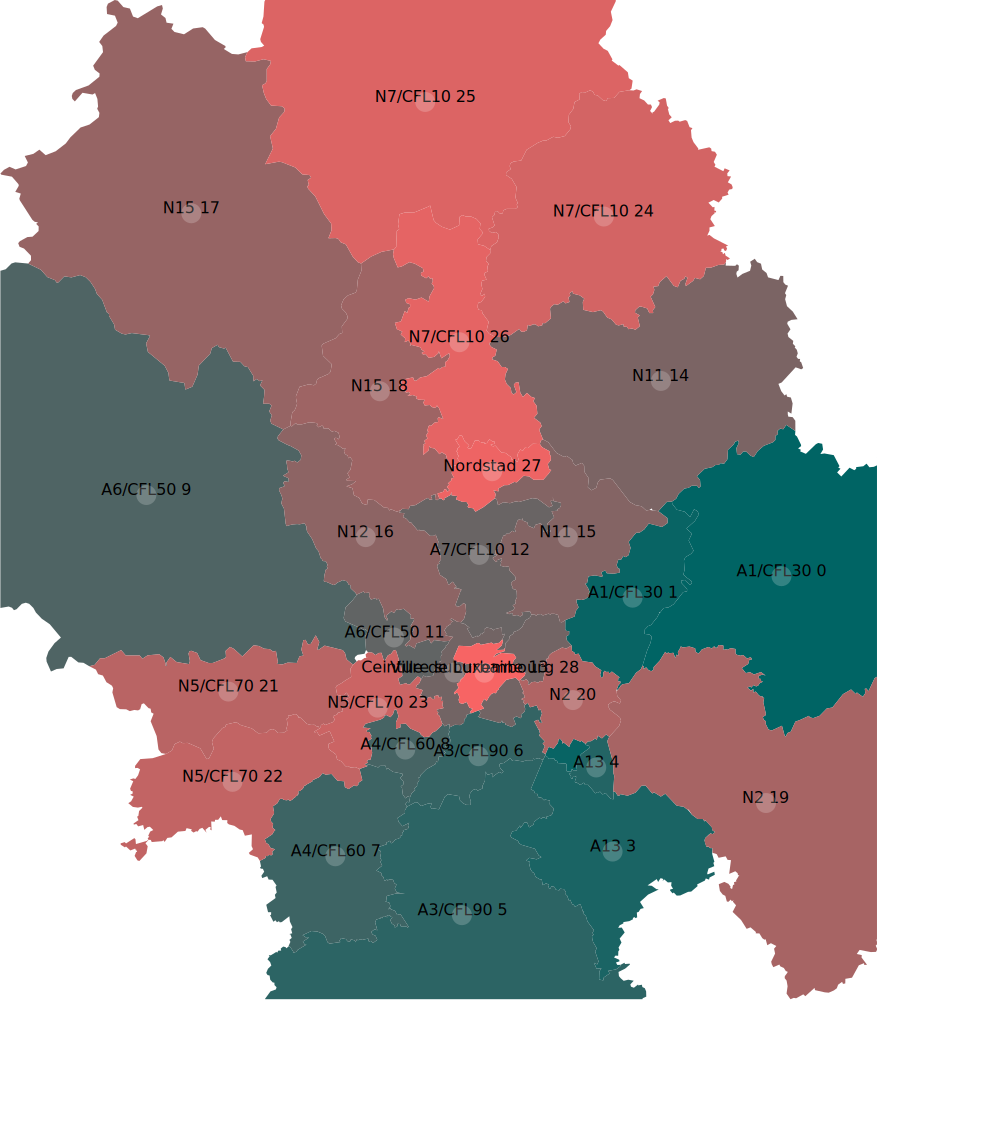

In [173]:
svg = f'<svg width="100%"  height="600" viewBox="0 0 {width} {height}">'
for corridor in svg_export.itertuples():
    group = [f'<path d="M {path}" />' for path in corridor.paths]
    group = ''.join(group)
    group = f'<g style="fill:rgb({corridor.Index / len(svg_export) * 255}, 100, 100)">{group}</g>'
    svg += group
    
for corridor in svg_export.itertuples():
    if corridor.centroid is None: continue
    svg += f'<text x="{corridor.centroid[0]}" y="{corridor.centroid[1]}" class="small" text-anchor="middle" style="fill:black">{corridor.corridor} {corridor.Index}</text>'
    svg += f'<circle cx="{corridor.centroid[0]}" cy="{corridor.centroid[1]}" r="10" style="opacity:0.2; fill:white" />'

svg += '</svg>'
SVG(svg)

Alright, time to export to JSON

In [174]:
svg_export.reset_index().to_json('zones.json', orient='records')

In [178]:
svg_export[['paths', 'centroid']].to_json('zone_paths.json', orient='records')